In [1]:
import os
from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np
import dask.dataframe as dd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import multiprocessing
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.enable()

# 0. Introduction

This kernel is diveded as follows:
    
    1. Some EDA to understand the data: type of features, cardinality, missing values, skewness, correlation between features etc.
    2. Cells to create the processed data set

# 1. Some EDA to understand the data

In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'UacLuaenable':                                         'float64', 
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', 
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', 
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', 
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', 
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', 
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', 
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', 
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', 
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

continuous_columns = [  # All the columns which have a real continuous data
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges',
    'Census_OSBuildNumber',
    'Census_OSBuildRevision',
    'Census_ThresholdOptIn',
    'OsBuild'
]

true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

bool_columns = [
    'IsBeta',
    'IsSxsPassiveMode',
    'Census_IsPortableOperatingSystem',
    'Census_IsSecureBootEnabled',
    'Census_IsTouchEnabled',
    'Census_IsPenCapable',
    'HasTpm',
    'Census_HasOpticalDiskDrive'
]

frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier'
]

In [5]:
%%time
df_train = pd.read_csv("train.csv")

<string>:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 1min 33s


In [8]:
df_test = pd.read_csv("test_sampled.csv")

C:\Users\jordi\Anaconda3\envs\py3iaml\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_test.shape

(334555, 86)

In [11]:
train.shape
categorical = train.select_dtypes(include='category').columns.tolist()

In [12]:
categorical.append('Census_InternalBatteryType')
categorical.append('SmartScreen')

In [13]:
binary_variables = [c for c in train.columns if train[c].nunique() == 2]
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

## Checking the distribution type of fetures

([<matplotlib.patches.Wedge at 0x1c347b46d68>,
 [Text(-0.124745,-1.0929,'categorical_columns'),
  Text(0.434321,1.01063,'binary_variables'),
  Text(-0.603216,0.919853,'true_numerical_columns')],
 [Text(-0.0680429,-0.596129,'68.6%'),
  Text(0.236902,0.551251,'22.1%'),
  Text(-0.329027,0.501738,'9.3%')])

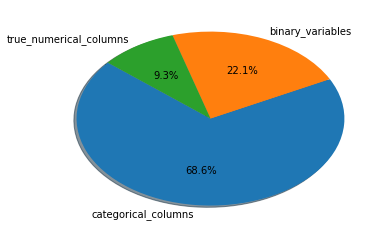

In [13]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}

plt.pie(list(variables.values()), labels=list(variables.keys()),
autopct='%1.1f%%', shadow=True, startangle=140)




## Cardinality of categorical features

In [15]:
cardinality = []
dict_card = {}
for c in categorical_columns:
    if c != 'MachineIdentifier':   
        dict_card[c] = train[c].nunique()    
        
        
dict_card = {k: v for k, v in sorted(dict_card.items(), key=lambda x: x[1])}

In [16]:
card_ = pd.DataFrame.from_dict(dict_card, orient='index')
card_

,0
PuaMode,1
Census_IsWIMBootEnabled,1
Processor,3
Census_DeviceFamily,3
Census_ProcessorClass,3
Census_OSArchitecture,3
Platform,4
Census_ProcessorManufacturerIdentifier,4
Census_PrimaryDiskTypeName,4
ProductName,5


## Skewness of categorical features

In [18]:
pd.options.display.float_format = '{:,.4f}'.format
sk_df = pd.DataFrame([{'column': c, 'uniq': train[c].nunique(), 'skewness': train[c].value_counts(normalize=True).values[0] * 100} for c in train.columns])
sk_df = sk_df.sort_values('skewness', ascending=False)
sk_df.head(20)

,column,skewness,uniq
75,Census_IsWIMBootEnabled,100.0000,2
5,IsBeta,99.9992,2
69,Census_IsFlightsDisabled,99.9990,2
68,Census_IsFlightingInternal,99.9986,2
27,AutoSampleOptIn,99.9971,2
71,Census_ThresholdOptIn,99.9749,2
29,SMode,99.9537,2
65,Census_IsPortableOperatingSystem,99.9455,2
28,PuaMode,99.9134,2
35,Census_DeviceFamily,99.8383,3


#### Drop high skewed features

In [10]:
train.drop(sk_df[sk_df['skewness']>99].column,axis=1, inplace=True)

## Missing values

In [11]:
missing_=(train.isnull().sum()/train.shape[0]).sort_values(ascending=False)
missing_.head(10)

Census_ProcessorClass                   0.9959
DefaultBrowsersIdentifier               0.9514
Census_InternalBatteryType              0.7105
SmartScreen                             0.3561
OrganizationIdentifier                  0.3084
CityIdentifier                          0.0365
Wdft_IsGamer                            0.0340
Wdft_RegionIdentifier                   0.0340
Census_InternalBatteryNumberOfCharges   0.0301
Census_FirmwareManufacturerIdentifier   0.0205
dtype: float64

In [12]:
missing_.drop(missing_[missing_>0.99].index, axis=0, inplace=True)
train.drop('Census_ProcessorClass', axis=1, inplace=True)
missing_.drop(missing_[missing_<0.1].index, axis=0, inplace=True)

## Impute missing values with 0

In [13]:
train['DefaultBrowsersIdentifier'].fillna(0,inplace=True)
test['DefaultBrowsersIdentifier'].fillna(0,inplace=True)
train.replace({'OrganizationIdentifier': {np.nan: 0}}, inplace=True)
test.replace({'OrganizationIdentifier': {np.nan: 0}}, inplace=True)

## Correcting misspelling

In [14]:
trans_dict = {
    '˙˙˙': 'unknown', 'unkn': 'unknown', np.nan: 'unknown'
}
train.replace({'Census_InternalBatteryType': trans_dict}, inplace=True)

In [15]:
trans_dict = {
    'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On', 'requireadmin': 'RequireAdmin', 'OFF': 'Off', 
    'Promt': 'Prompt', 'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
    '00000000': '0', '&#x03;': '3', np.nan: 'NoExist'
}
train.replace({'SmartScreen': trans_dict}, inplace=True)

In [39]:
for col_name in train.columns:
    if col_name in continuous_columns:
        mean = train[col_name].astype('float32').mean()
        train[col_name].fillna(mean,inplace=True)
    elif col_name!= 'HasDetections':
        train[col_name].replace(np.nan,"",inplace=True)

In [41]:
for col in categorical:
    if col in train.columns:
        train[col] = train[col].astype('category')

In [42]:
train['SmartScreen'] = train.SmartScreen.astype('category')
train['Census_InternalBatteryType'] = train.Census_InternalBatteryType.astype('category')

cate_cols = train.select_dtypes(include='category').columns.tolist()

In [49]:
le = LabelEncoder()

for col in categorical:
    print(col)
    train[col] = le.fit_transform(train[col])

MachineIdentifier
ProductName
EngineVersion
AppVersion
AvSigVersion
Platform
Processor
OsVer
OsPlatformSubRelease
OsBuildLab
SkuEdition
SmartScreen
Census_MDC2FormFactor
Census_PrimaryDiskTypeName
Census_ChassisTypeName
Census_PowerPlatformRoleName
Census_OSVersion
Census_OSArchitecture
Census_OSBranch
Census_OSEdition
Census_OSSkuName
Census_OSInstallTypeName
Census_OSWUAutoUpdateOptionsName
Census_GenuineStateName
Census_ActivationChannel
Census_FlightRing
Census_InternalBatteryType
SmartScreen


## Check correlation between features and see what we can remove

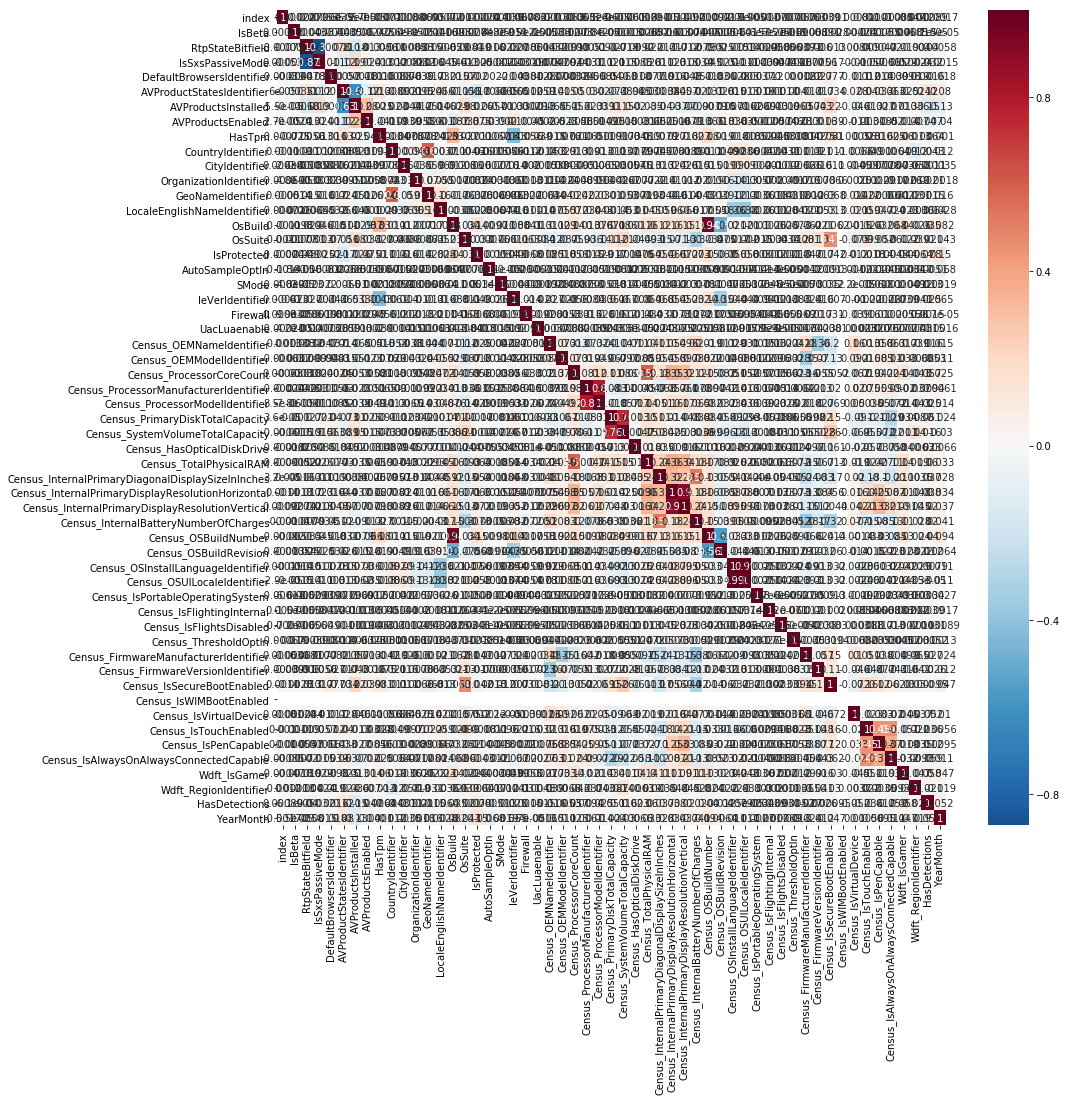

In [22]:
correlation_matrix = train.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, cmap='RdBu_r', annot=True, center=0.0)
plt.show()

In [24]:
# This cell is to decide which column to drop, we drop the ones with the highest cardinality

print("Correlation columns over 99%")
print("Platform categories: ",train.Platform.nunique())
print("OsVer categories: ",train.OsVer.nunique(), "\n")

print("Census_OSEdition categories: ",train.Census_OSEdition.nunique())
print("Census_OSSkuName categories: ",train.Census_OSSkuName.nunique(), '\n')

print("Census_OSInstallLanguageIdentifier categories: ",train.Census_OSInstallLanguageIdentifier.nunique())
print("Census_OSUILocaleIdentifier categories: ",train.Census_OSUILocaleIdentifier.nunique(), '\n')

print('Census_OSArchitecture categories: ',train.Census_OSArchitecture.nunique())
print('Processor categories: ',train.Processor.nunique())

Comparing over 99% correlation columns
Platform categories:  4
OsVer categories:  58 

Census_OSEdition categories:  33
Census_OSSkuName categories:  30 

Census_OSInstallLanguageIdentifier categories:  40
Census_OSUILocaleIdentifier categories:  147 

Census_OSArchitecture categories:  3
Processor categories:  3


In [ ]:
features_to_remove_corr = ['Platform', 'Census_OSSkuName', 'Census_OSInstallLanguageIdentifier','Census_OSArchitecture']
train.drop(features_to_remove_corr, axis=1, inplace=True)

# 2. Execute these cells to create a cleaned dataset

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'UacLuaenable':                                         'float64', # was 'float32'
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', # was 'float16'
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

continuous_columns = [  # All the columns which have a real continuous data
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges',
    'Census_OSBuildNumber',
    'Census_OSBuildRevision',
    'Census_ThresholdOptIn',
    'OsBuild'
]

true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

bool_columns = [
    'IsBeta',
    'IsSxsPassiveMode',
    'Census_IsPortableOperatingSystem',
    'Census_IsSecureBootEnabled',
    'Census_IsTouchEnabled',
    'Census_IsPenCapable',
    'HasTpm',
    'Census_HasOpticalDiskDrive'
]

frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier'
]



In [4]:
df_train = pd.read_csv('train.csv', dtype=dtypes, low_memory=True)

## Removing redundant features

In [5]:
columns_to_remove= ['Census_IsWIMBootEnabled','IsBeta',"Census_IsFlightsDisabled", 'Census_IsFlightingInternal',
                   'AutoSampleOptIn','Census_ThresholdOptIn','SMode','Census_IsPortableOperatingSystem',
                   'PuaMode','Census_DeviceFamily','UacLuaenable','Census_IsVirtualDevice',
                   'Platform', 'Census_OSSkuName', 'Census_OSInstallLanguageIdentifier',
                    'Census_OSArchitecture','Census_ProcessorClass']

In [6]:
#Drop columns as analyzed above
df_train.drop(columns_to_remove, axis=1, inplace=True)

In [7]:
#Missing value imputation
df_train['DefaultBrowsersIdentifier'].fillna(0,inplace=True)

trans_dict = {
    '˙˙˙': 'unknown', 'unkn': 'unknown', np.nan: 'unknown'
}
df_train.replace({'Census_InternalBatteryType': trans_dict}, inplace=True)

trans_dict = {
    'off': 'Off', '&#x02;': '2', '&#x01;': '1', 'on': 'On', 'requireadmin': 'RequireAdmin', 'OFF': 'Off', 
    'Promt': 'Prompt', 'requireAdmin': 'RequireAdmin', 'prompt': 'Prompt', 'warn': 'Warn', 
    '00000000': '0', '&#x03;': '3', np.nan: 'NoExist'
}
df_train.replace({'SmartScreen': trans_dict}, inplace=True)

df_train.replace({'OrganizationIdentifier': {np.nan: 0}}, inplace=True)

In [8]:
#Fill with mean value for continuous columns
for col_name in df_train.columns:
    if col_name in continuous_columns:
        col_type = df_train[col_name].dtype 
        mean = df_train[col_name].astype(col_type).mean()
        df_train[col_name].fillna(mean,inplace=True)
    else:
        #Fill with empty string
        df_train[col_name].replace(np.nan,"Empty",inplace=True)
df_train['Census_ProcessorCoreCount'].replace(np.nan,0,inplace=True)

## Feature engineering

In [14]:
#Getting the timestamp from OsBuildLab and then drop the column
df_train['OsBuildReleaseYearMonth'] = df_train['OsBuildLab'].str.slice(start=-11, stop=-7)
df_train['OsBuildReleaseYearMonth'] = pd.to_numeric(df_train['OsBuildReleaseYearMonth']).astype('float16')

# AS timestamp
datedictAS = np.load('AvSigVersionTimestamps.npy')[()]
df_train['DateAS'] = df_train['AvSigVersion'].map(datedictAS)

# OS timestamp
datedictOS = np.load('OSVersionTimestamps.npy')[()]
df_train['DateOS'] = df_train['Census_OSVersion'].map(datedictOS)

# ENGINEERED FEATURE #1
df_train['AppVersion2'] = df_train['AppVersion'].map(lambda x: np.int(x.split('.')[1]))

# ENGINEERED FEATURE #2
df_train['Lag1'] = df_train['DateAS'] - df_train['DateOS']
df_train['Lag1'] = df_train['Lag1'].map(lambda x: x.days//7)

# ENGINEERED FEATURE #3
df_train['Lag5'] = datetime(2018,7,26) - df_train['DateAS']
df_train['Lag5'] = df_train['Lag5'].map(lambda x: x.days//1)
df_train.loc[ df_train['Lag5']<0, 'Lag5' ] = 0
df_train['Lag5'] = df_train['Lag5'].astype('float32') # allow for NAN

# ENGINEERED FEATURE #4
df_train['driveA'] = df_train['Census_SystemVolumeTotalCapacity'].astype('float')/df_train['Census_PrimaryDiskTotalCapacity'].astype('float')
df_train['driveA'] = df_train['driveA'].astype('float32') 


# ENGINNERED FEATURE #5
df_train['driveB'] = df_train['Census_PrimaryDiskTotalCapacity'].astype('float') - df_train['Census_SystemVolumeTotalCapacity'].astype('float')
df_train['driveB'] = df_train['driveB'].astype('float32') 


del df_train['DateAS'], df_train['DateOS'] #, df_train['DateBL']
del datedictAS, datedictOS
gc.collect()

28

## Execute only these cells in order to create sampled raw datasets

In [15]:
timestamp = np.load('AvSigVersionTimestamps.npy')[()]
# ADD TIMESTAMPS
df_train['Date'] = df_train['AvSigVersion'].map(timestamp)
df_train['YearMonth'] = df_train['Date'].map(lambda x: 100*x.year+x.month)

In [16]:
#Create a sample train set with 20% of total data
df_train['MachineIdentifier'] = df_train.index.astype('uint32')
df_train['YearMonth']= pd.to_numeric(df_train['YearMonth']).astype('float32')
df_train_sample = df_train.loc[df_train['YearMonth'] <= 201808.0]
df_test_sample = df_train.loc[df_train['YearMonth'] == 201809.0]
df_train_sample=df_train_sample.reset_index()
df_test_sample = df_test_sample.reset_index()

np.random.seed(seed=123)
train_set_size = round(8921483*0.25)
test_set_size = round(train_set_size*0.15)

# Training set 25% of the total data and test set 15% of training set
random_sampling_train = np.random.choice(range(df_train_sample.shape[0]), train_set_size, replace=False)
random_sampling_test = np.random.choice(range(df_test_sample.shape[0]), test_set_size, replace=False)
df_sampled_train = df_train_sample.iloc[random_sampling_train]
df_sampled_test = df_test_sample.iloc[random_sampling_test]


In [17]:
#Drop Unwanted index, YearMonth, Date Features and MachineIdentifier
df_sampled_train.drop(['index','YearMonth','Date','MachineIdentifier'],axis=1,inplace=True)
df_sampled_test.drop(['index','YearMonth','Date','MachineIdentifier'],axis=1,inplace=True)

In [27]:
#Save the sampled train and test sets
export_csv = df_sampled_train.to_csv(r'sample_train_engineered.csv', index=None, header=True)
export_csv = df_sampled_test.to_csv(r'sample_test_engineered.csv', index=None, header=True)

In [13]:
#Save the sampled train and test sets
export_csv = df_sampled_train.to_csv(r'sample_train_removed_features.csv', index=None, header=True)
export_csv = df_sampled_test.to_csv(r'sample_test_removed_features.csv', index=None, header=True)

# Do this to load the sampled data sets 

In [40]:
train = pd.read_csv('sample_train_engineered.csv', low_memory=True)
test = pd.read_csv('sample_test_engineered.csv', low_memory=True)